In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "encoder"
task = "rte"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "encoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


## Comput CKA per prompt across layers

In [5]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    "mnli_crowdsource_with_targets",
    "based_on_previous_passage_with_targets",
    "infer_with_targets",
    "follow_with_targets",
    "imply_with_targets",
    "guaranteed_with_targets",
    "justified_with_targets",
    "must_be_true_with_targets",
    "should_assume_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
    "gpt_3_cat_dog_with_targets_yes_no",
    "gpt_3_yes_no_without_targets",
    "words_appear_with_targets",
    "similar_words_with_targets",
    "start_with_the_with_targets",
    "same_meaning_with_targets",
    "paraphrase_with_targets",
    "paraphrase_r_with_targets",
    "summarize_with_targets",
    "inflection_with_targets",
    "null_pattern_with_targets",
    "null_pattern_r_with_targets",
    "null_pattern_without_targets",
    "null_pattern_r_without_targets",
    "premise_only_with_targets",
    "premise_only_without_targets",
    "hypothesis_only_with_targets",
    "hypothesis_only_without_targets",
    "sentiment_with_targets", 
    "sentiment_cat_dog_with_targets"
]

In [6]:
representations = {}

for _, row in tqdm(df.iterrows(), desc="patterns"):
    prompt_name = row['name']
    
    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}
        
        for layer in range(0, 25):
            layer_key = f"{module}-{layer}"

            if layer_key not in representations[prompt_name]:
                representations[prompt_name][layer_key] = {}

            # file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg-nopad.hdf5"
            
            # load hidden representations from hdf5 file
            representations[prompt_name][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

patterns: 32it [00:38,  1.22s/it]


In [7]:
representations.keys()

dict_keys(['gpt_3_yes_no_with_targets', 'mnli_crowdsource_with_targets', 'based_on_previous_passage_with_targets', 'infer_with_targets', 'follow_with_targets', 'imply_with_targets', 'guaranteed_with_targets', 'justified_with_targets', 'must_be_true_with_targets', 'should_assume_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_cat_dog_with_targets_yes_no', 'gpt_3_yes_no_without_targets', 'words_appear_with_targets', 'similar_words_with_targets', 'start_with_the_with_targets', 'same_meaning_with_targets', 'paraphrase_with_targets', 'paraphrase_r_with_targets', 'summarize_with_targets', 'inflection_with_targets', 'null_pattern_with_targets', 'null_pattern_r_with_targets', 'null_pattern_without_targets', 'null_pattern_r_without_targets', 'premise_only_with_targets', 'premise_only_without_targets', 'hypothesis_only_with_targets', 'hypothesis_only_without_targets', 'sentiment_with_targets', 'sentiment_cat_dog_with_targets'])

In [8]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in tqdm(list(representations.keys())[:], desc="patterns"):
    cka_scores = []
    for layer1 in representations[pattern].keys():
        cka_scores_layer1 = []
        for layer2 in representations[pattern].keys():
            cka_score = np_cka.linear_CKA(representations[pattern][layer1], representations[pattern][layer2])
            cka_scores_layer1.append(cka_score)
        cka_scores.append(cka_scores_layer1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_pattern[pattern] = cka_scores

patterns: 100%|██████████| 32/32 [09:21<00:00, 17.53s/it]


In [9]:
cka_scores_pattern['gpt_3_yes_no_with_targets'].shape

(25, 25)

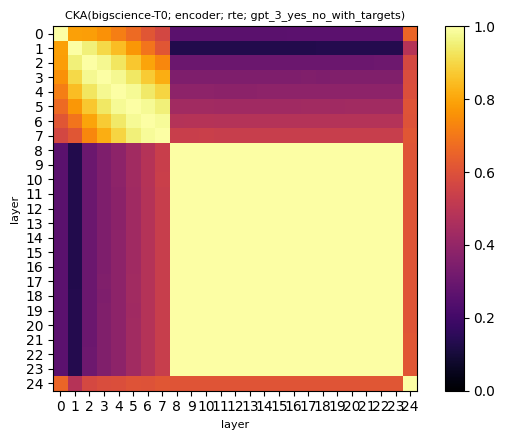

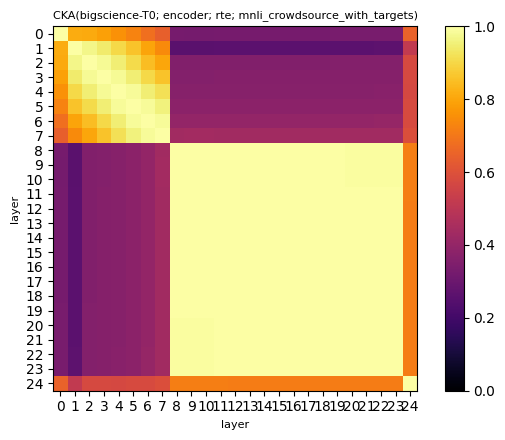

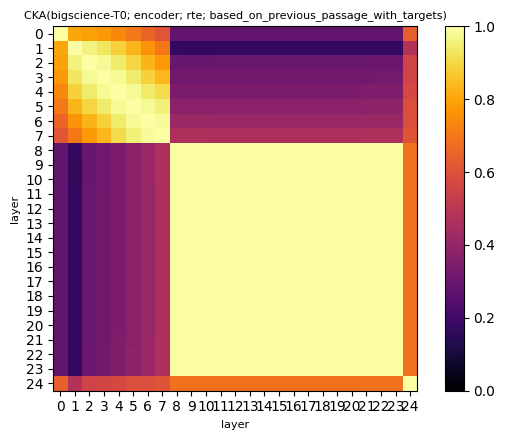

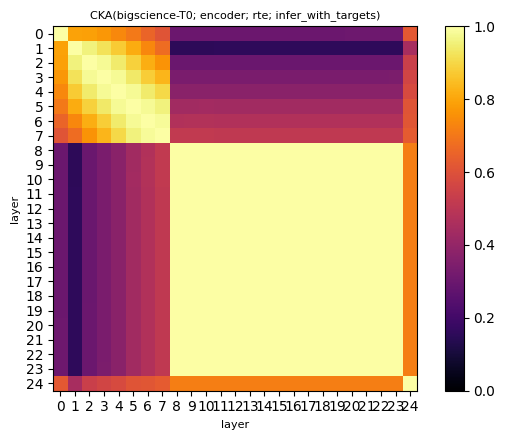

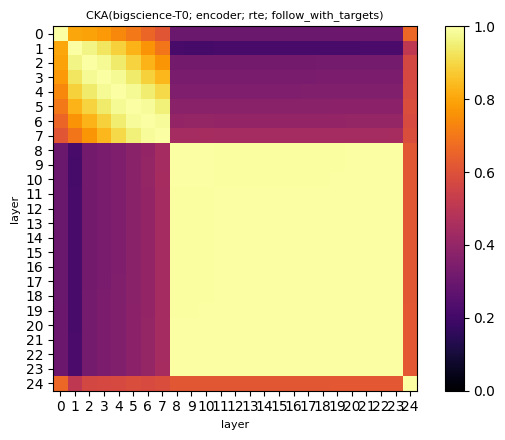

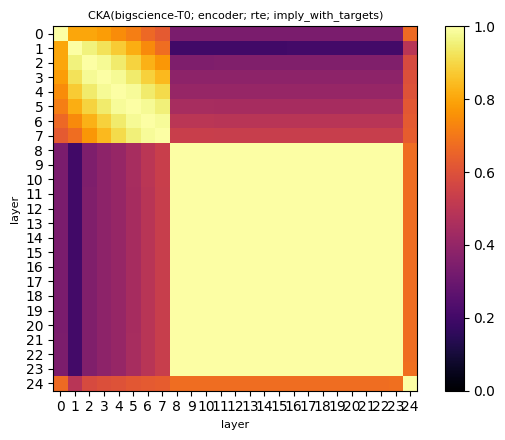

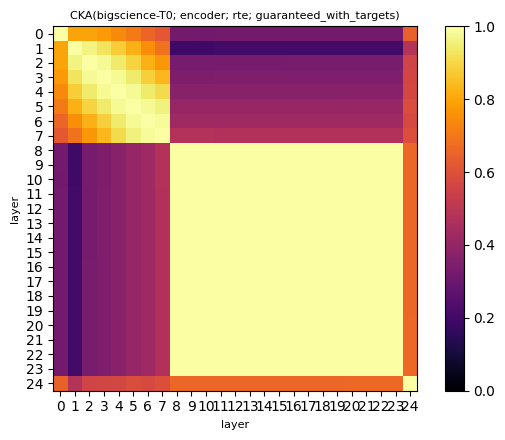

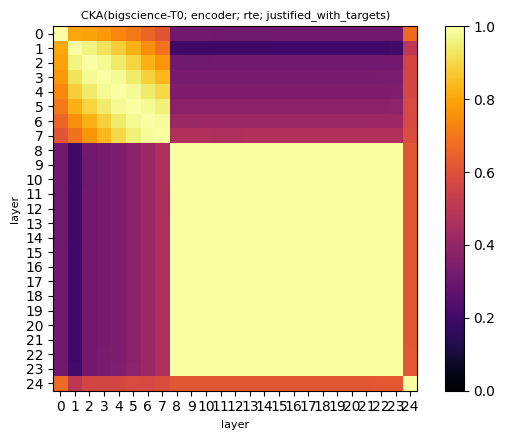

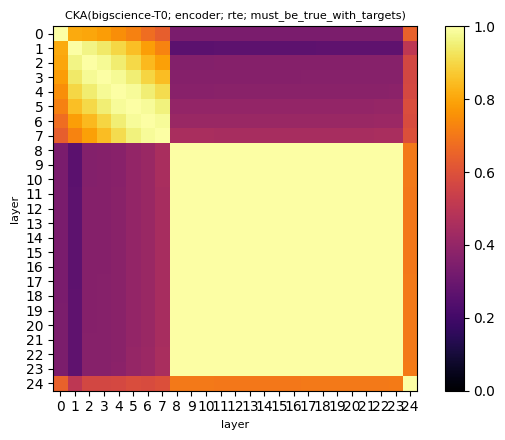

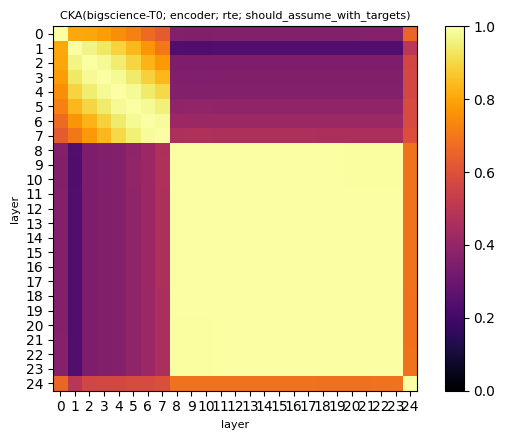

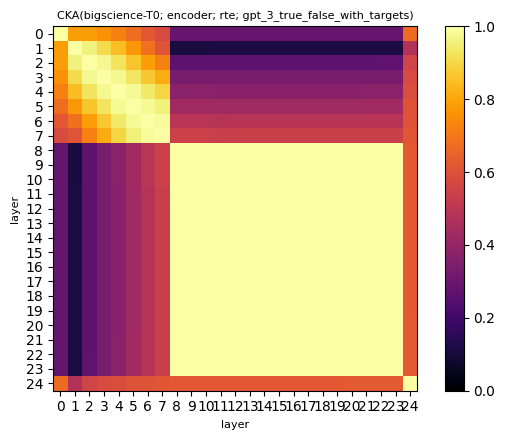

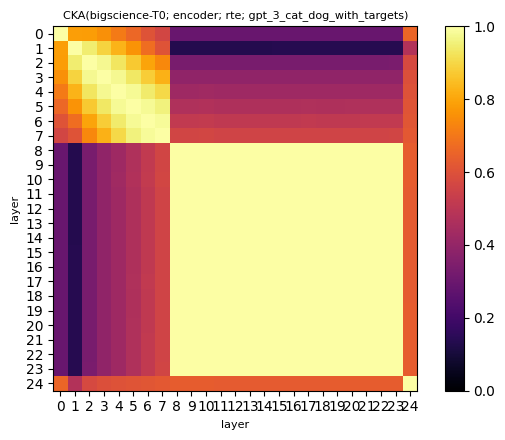

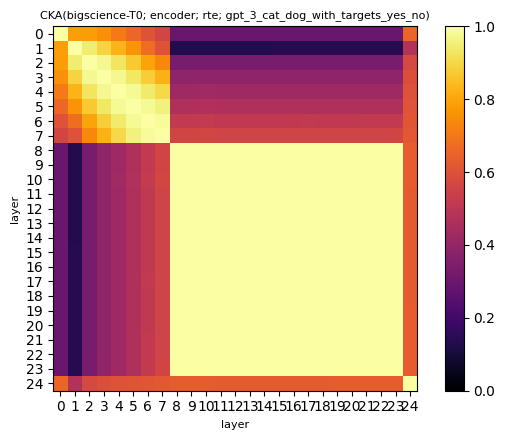

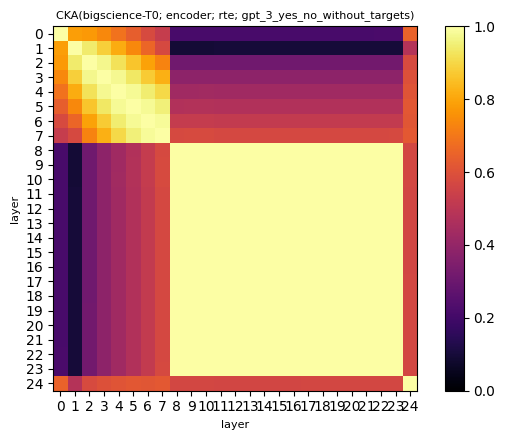

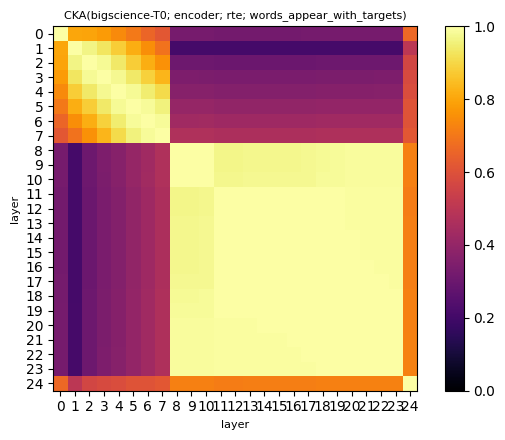

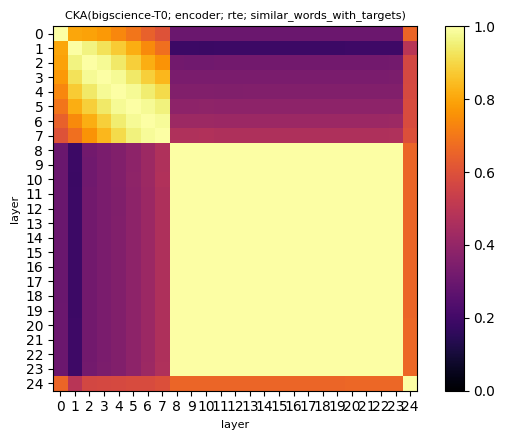

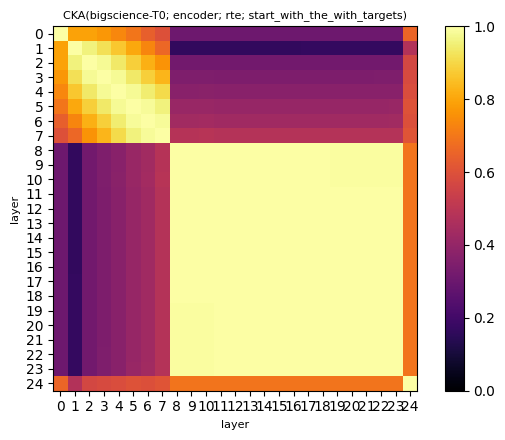

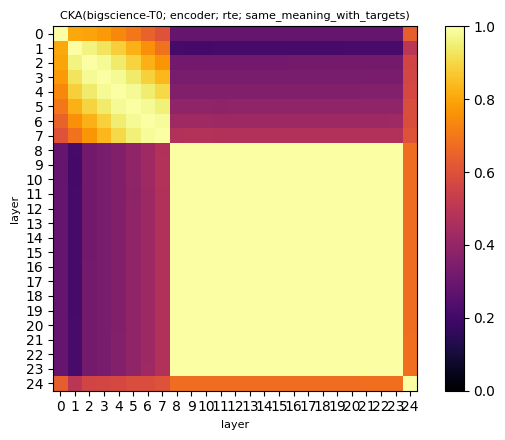

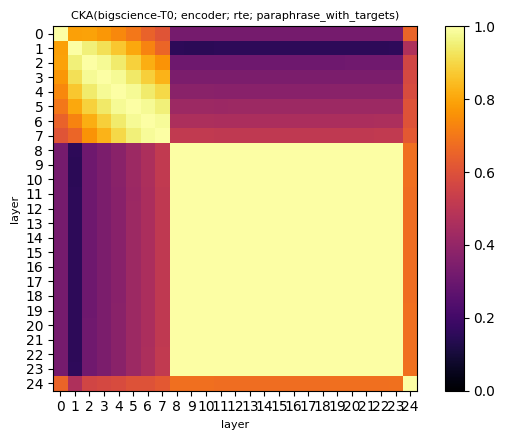

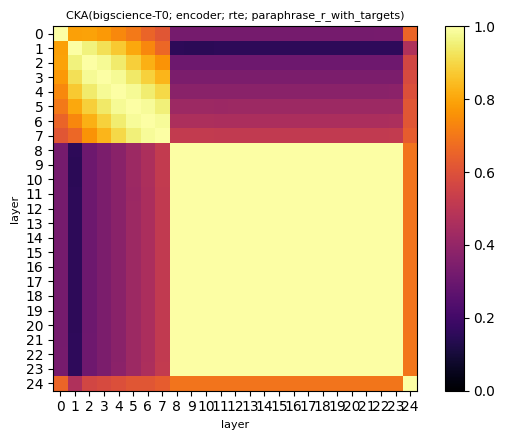

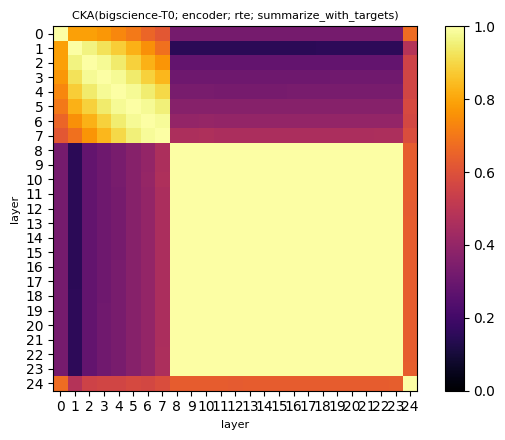

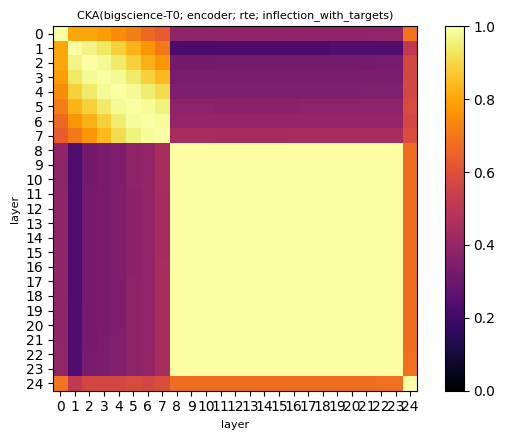

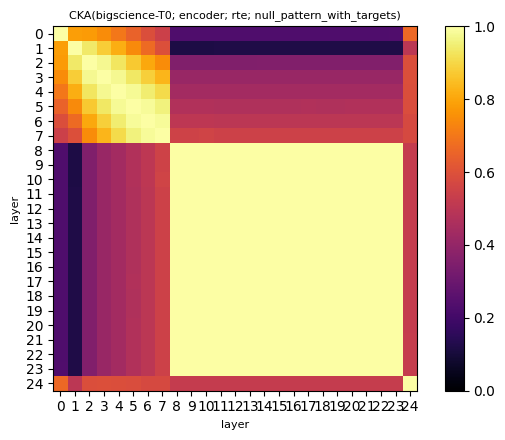

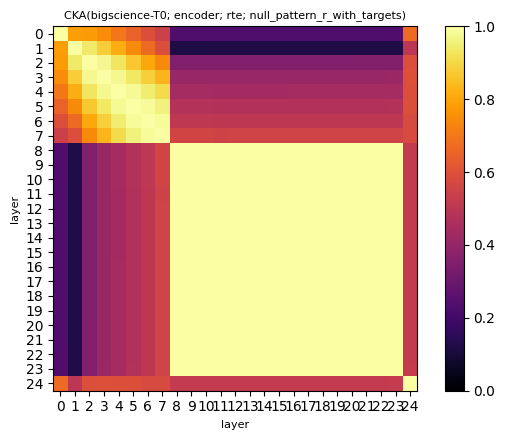

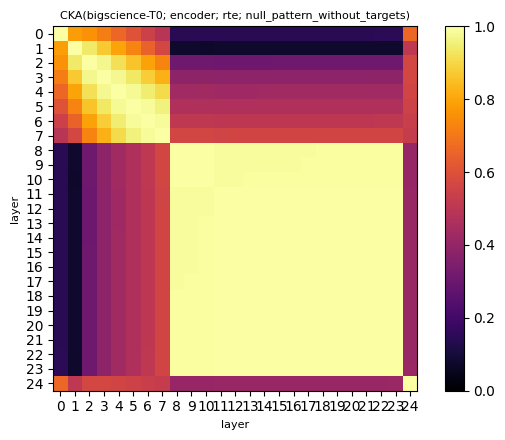

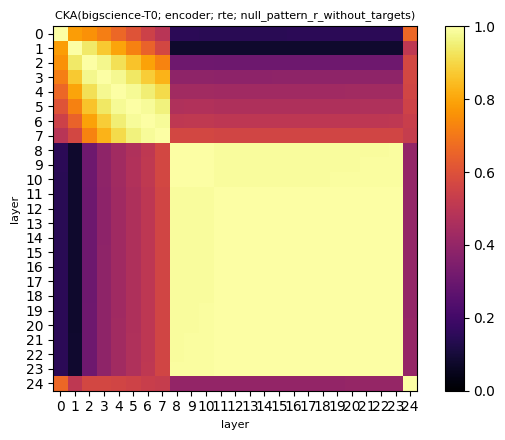

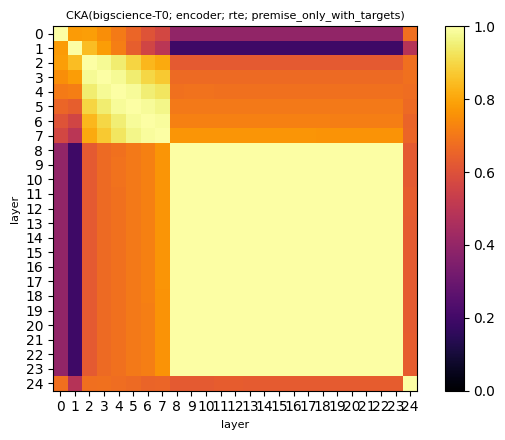

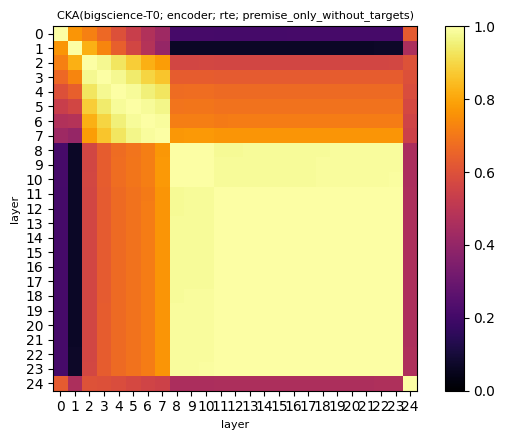

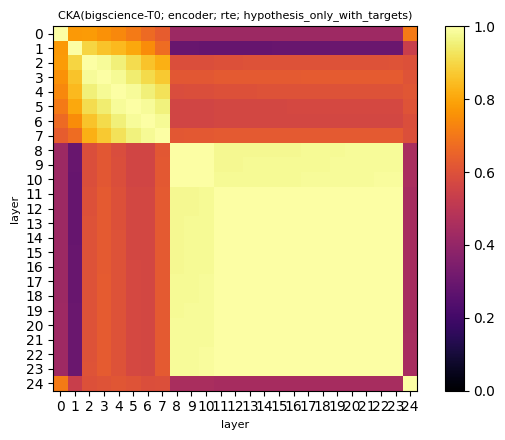

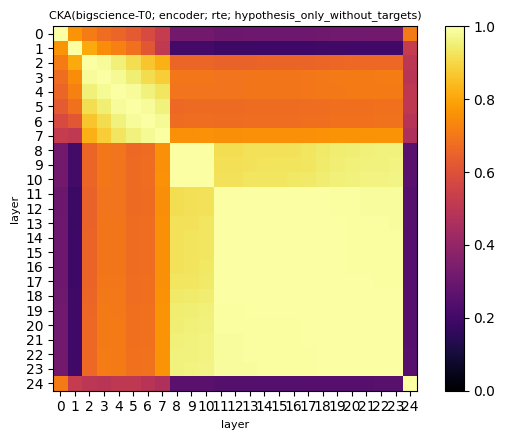

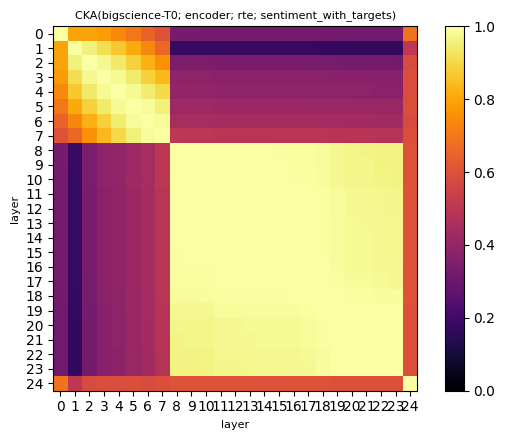

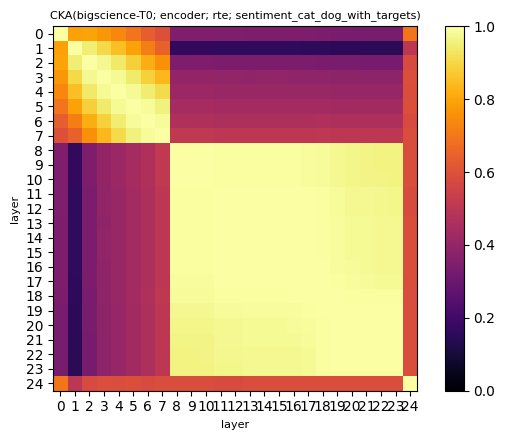

In [10]:
for pattern in list(cka_scores_pattern.keys())[:]:
    values = cka_scores_pattern[pattern]

    fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("layer", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("layer", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    axes.set_title(f"CKA({model}; {module}; {task}; {pattern})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


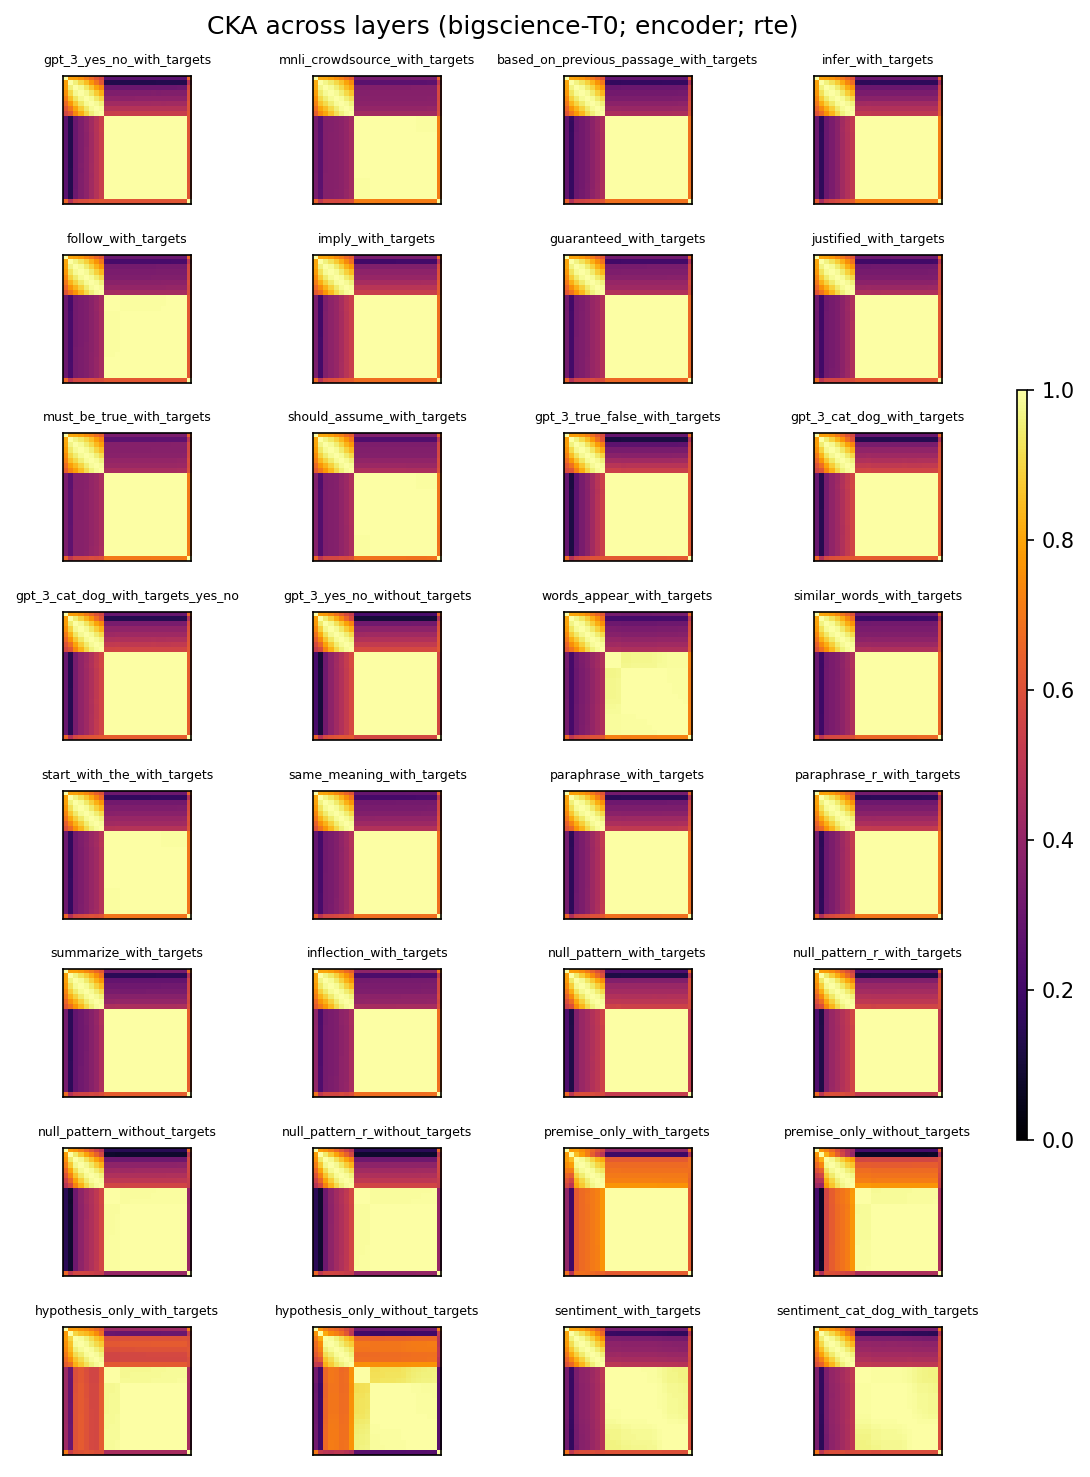

In [23]:
plt.figure(figsize=(7.0, 10.0), dpi=150)

for l, pattern in enumerate(cka_scores_pattern.keys()):
    values = cka_scores_pattern[pattern]

    plt.subplot(8, 4, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"{pattern}", fontsize=6)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.23, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"CKA across layers ({model}; {module}; {task})")
plt.tight_layout(h_pad=1.0)
plt.show()
plt.close();